In [1]:
import pandas as pd
import numpy as np
from scipy.stats import chi2_contingency
import re
import warnings
warnings.filterwarnings('ignore')
from scipy.stats import f_oneway
from matplotlib import pyplot as plt
import matplotlib
import scipy

In [2]:
base_data=pd.read_csv('loan.csv')

# Variable Understanding

1. ID :- Loan ID
2. Member ID :- Customer ID
3. Loan Status :- Status on the loan

###### Variables are defined in three border category
1. Internal
2. Bureau
3. Demographic

###### Internal
1. last_credit_pull_d :- Bureau pull on which date.
2. loan_amnt :- Customer asked amount.
3. Funded_Amnt :- Total amount approved by lending club.
4. funded_amnt_inv :- Actual loan amount given to customer by lender.
5. grade :- grade or type of the loan.
6. sub_grade :- sub_grade of the loan.
7. term :- duartion of the loan.
8. title :- loan title provide by the customer.(Unstructure format)
9. verification status :- income is verified or not.
10. installment :- emi of the loan.
11. int_arte :- interest rate on the loan.
12. issue_D :- issue date of the loan.


###### Bureau
1. Delinq_2yrs :- number of times dpd 30 plus in last 2 years.
2. earliest_cr_line :- date of first loan taken.
3. inq_last_6_months :- inquiry in last 6 months.
4. mths_since_last_delinq :- how many month the customer is clean with out any delinquency.
5. mths_since_last_record :- what is last time customer is recorded in bureau.
6. open_Acc :- number of active loans of the customer.
7. pub_rec :- Number of derogatory public records
8. pub_rec_bankruptcies :- Number of public record bankruptcies
9. revol_bal :- Credit revolving amount. Loan taken of 50K when is reducing to match the same taken another loan to make amount back to 50K.
10. total_acc :- total number of trad lines a customer have.
11. dti :- A ratio calculated using the borrower’s total monthly debt payments on the total debt obligations, excluding mortgage and the requested LC loan, divided by the borrower’s self-reported monthly income.

###### Demographic
1. addr_state :- state of the customer.
2. decs :- purpose of the laon describe by the customer. (Unstructure format)
3. home_ownership :- If customer have home or not. Not verified field.
4. Purpose :- drop down field of purpose of customer.
5. zip_code :- hashed zipcode of the customer.
6. verfication_status :- Income is verified or not.


In [3]:
# ID is basically the loan ID
# Member ID refers to as customer id
# Difference is one customer can take mulitple loan
# so one member id can have one or more loan id
# checking the hypothesis
print(len(base_data.id.unique()))
print(len(base_data.member_id.unique()))
print(len(base_data))
# as both have same unique value which is same as length of the database.
# one loan per customer has disbursed.

39717
39717
39717


In [4]:
# checking for the event distribution on overall base
# and missing values
print(base_data['loan_status'].value_counts(dropna=False,normalize=True))

print(str((base_data['loan_status'].value_counts(dropna=False,normalize=True)[0])*100) + "% of the population are fully paid customers.\n"
+ str((base_data['loan_status'].value_counts(dropna=False,normalize=True)[1])*100) + "2.87% are in active non default customers and \n" +
      str((base_data['loan_status'].value_counts(dropna=False,normalize=True)[2])*100) + "% customer have defaulted in the duration of whole tenure.")

Fully Paid     0.829620
Charged Off    0.141677
Current        0.028703
Name: loan_status, dtype: float64
82.96195583755068% of the population are fully paid customers.
14.1677367374172272.87% are in active non default customers and 
2.8703074250321023% customer have defaulted in the duration of whole tenure.


In [5]:
base_data['loan_status'].value_counts(dropna=False)

Fully Paid     32950
Charged Off     5627
Current         1140
Name: loan_status, dtype: int64

# Checking for the data types of all the variables and correcting all the data types and format.

In [6]:
# checking for the data types of all the variables and correcting all the data types

# making month to interger value to make use of it
base_data.term=base_data.term.str.replace('months',"")
base_data.term=base_data.term.astype('int')

# replace % from the column int_rate and making it as number for further use
base_data.int_rate=base_data.int_rate.str.replace("%","")
base_data.int_rate=base_data.int_rate.astype('float')
base_data.int_rate=base_data.int_rate

# removing years from emp_length to make in int
# -1 stand for nan value, 0 for 0-1 years 1 means 1 year, 2 means 2 years and so on so forth.
base_data['emp_length']=base_data['emp_length'].str.replace('year|s|\\+','',regex=True)
base_data['emp_length']=base_data['emp_length'].str.replace('< 1','0')
base_data['emp_length'].fillna(-1,inplace=True)
base_data['emp_length']=base_data['emp_length'].astype('int')

# in base_Data['home_ownership'] three values as coming as none setting those value to other category
base_data['home_ownership']=np.where(base_data['home_ownership']=="NONE","OTHER",base_data['home_ownership'])

# converting issue date and earliest_cr_line and last_pymnt_d and next_pymnt_d and last_credit_pull_d to date format
base_data['issue_d']=pd.to_datetime(base_data['issue_d'],format="%b-%y")
base_data['earliest_cr_line']=pd.to_datetime(base_data['earliest_cr_line'],format="%b-%y")
base_data['last_pymnt_d']=pd.to_datetime(base_data['last_pymnt_d'],format="%b-%y")
base_data['next_pymnt_d']=pd.to_datetime(base_data['next_pymnt_d'],format="%b-%y")
base_data['last_credit_pull_d']=pd.to_datetime(base_data['last_credit_pull_d'],format="%b-%y")

# converting revol_util in float format
base_data['revol_util']=base_data['revol_util'].str.replace("%","")
base_data['revol_util']=base_data['revol_util'].astype('float')

# Dropping emp_title :- as in current date this variable is replaced by employer name.
# any analysis done on this will not stand true in current date.
del base_data['emp_title']

# as all the loans are individual dropping application_type,verification_status_joint,annual_inc_joint
base_data.drop(['application_type','verification_status_joint','annual_inc_joint'],axis=1,inplace=True)

# dropping all the variables having all the null values
base_data.drop(base_data.columns[base_data.isnull().sum()==len(base_data)],axis=1,inplace=True)

# Dropping variables having single unique value
base_data.drop([i for i in base_data.columns if len(base_data[i].unique())==1],axis=1,inplace=True)

# Url :- No use as each customer have different url
# collections_12_mths_ex_med and chargeoff_within_12_mths and tax_liens :- Variability is too low only two value are flowing 0 and nan
# collection_recovery_fee,recoveries :- variable is used post charged off
base_data.drop(['url','collections_12_mths_ex_med','chargeoff_within_12_mths','tax_liens','collection_recovery_fee','recoveries'],axis=1,inplace=True)

# Event can be captured in two ways one is by seeing the whole tenure and second is making the snapshot of it, then checking for
# event rate and npa convergence. But in our case event is prepared in such a way that we are looking on the full tenure.
# keeping only those customer who have paid fully and who are defaulter or charged off. as intrim customer will be of no
# use as we are unable to see if customer paid the full payment or not.
# these customer can be use to make a prediction in future to put more efforts on collection of these type of customers.
Model_Building=base_data[base_data['loan_status'].isin(['Fully Paid','Charged Off'])]
Model_Building.reset_index(drop=True,inplace=True)

# below variables are used for current customer only
# next_pymnt_d,out_prncp,out_prncp_inv
Model_Building.drop(['next_pymnt_d','out_prncp','out_prncp_inv'],axis=1,inplace=True)

# Below variables are created after event date
# total_pymnt,total_pymnt_inv,last_pymnt_amnt, last_pymnt_d, total_rec_int, total_rec_late_fee, total_rec_prncp
Model_Building.drop(['total_pymnt','total_pymnt_inv','last_pymnt_amnt','last_pymnt_d','total_rec_int','total_rec_late_fee','total_rec_prncp'],axis=1,inplace=True)

# can be used for checking PSI and CSI of the model. Whether stable or not.
Outtime=base_data[~base_data['loan_status'].isin(['Fully Paid','Charged Off'])]
Outtime.reset_index(drop=True,inplace=True)

In [7]:
Model_Building.columns

Index(['id', 'member_id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv',
       'term', 'int_rate', 'installment', 'grade', 'sub_grade', 'emp_length',
       'home_ownership', 'annual_inc', 'verification_status', 'issue_d',
       'loan_status', 'desc', 'purpose', 'title', 'zip_code', 'addr_state',
       'dti', 'delinq_2yrs', 'earliest_cr_line', 'inq_last_6mths',
       'mths_since_last_delinq', 'mths_since_last_record', 'open_acc',
       'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'last_credit_pull_d',
       'pub_rec_bankruptcies'],
      dtype='object')

# Univariate Analysis

In [8]:
# Data Types of all the variables
Model_Building.dtypes

id                                 int64
member_id                          int64
loan_amnt                          int64
funded_amnt                        int64
funded_amnt_inv                  float64
term                               int32
int_rate                         float64
installment                      float64
grade                             object
sub_grade                         object
emp_length                         int32
home_ownership                    object
annual_inc                       float64
verification_status               object
issue_d                   datetime64[ns]
loan_status                       object
desc                              object
purpose                           object
title                             object
zip_code                          object
addr_state                        object
dti                              float64
delinq_2yrs                        int64
earliest_cr_line          datetime64[ns]
inq_last_6mths  

In [9]:
# Missing Values is all the columns
Model_Building.isnull().mean()*100

id                         0.000000
member_id                  0.000000
loan_amnt                  0.000000
funded_amnt                0.000000
funded_amnt_inv            0.000000
term                       0.000000
int_rate                   0.000000
installment                0.000000
grade                      0.000000
sub_grade                  0.000000
emp_length                 0.000000
home_ownership             0.000000
annual_inc                 0.000000
verification_status        0.000000
issue_d                    0.000000
loan_status                0.000000
desc                      32.472717
purpose                    0.000000
title                      0.028514
zip_code                   0.000000
addr_state                 0.000000
dti                        0.000000
delinq_2yrs                0.000000
earliest_cr_line           0.000000
inq_last_6mths             0.000000
mths_since_last_delinq    64.559193
mths_since_last_record    92.897322
open_acc                   0

In [10]:
# Analysing variable with missing values and imputing the missing values
print("-----------------------------------------------------------------")
print(Model_Building.isnull().mean()[Model_Building.isnull().mean()>0])
print("-----------------------------------------------------------------")

print("-----------------------------------------------------------------")
# Dropping variable because of unstruture format and missing rates.
Model_Building.drop(['desc','title'],axis=1,inplace=True)
print("-----------------------------------------------------------------")

print("-----------------------------------------------------------------")
# Dropping all the columns having higher missing rates.
print("Dropping all the below variables as they have higher missing rate")
print("If missing rate is higher than 70% dropping that variable")
print(Model_Building.isnull().mean()[Model_Building.isnull().mean()>0.70])
Model_Building.drop(Model_Building.isnull().mean()[Model_Building.isnull().mean()>0.70].index,axis=1,inplace=True)
print("-----------------------------------------------------------------")

print("-----------------------------------------------------------------")
# Remaining variable with missing values
print(Model_Building.isnull().mean()[Model_Building.isnull().mean()>0])
print("-----------------------------------------------------------------")

-----------------------------------------------------------------
desc                      0.324727
title                     0.000285
mths_since_last_delinq    0.645592
mths_since_last_record    0.928973
revol_util                0.001296
last_credit_pull_d        0.000052
pub_rec_bankruptcies      0.018068
dtype: float64
-----------------------------------------------------------------
-----------------------------------------------------------------
-----------------------------------------------------------------
-----------------------------------------------------------------
Dropping all the below variables as they have higher missing rate
If missing rate is higher than 70% dropping that variable
mths_since_last_record    0.928973
dtype: float64
-----------------------------------------------------------------
-----------------------------------------------------------------
mths_since_last_delinq    0.645592
revol_util                0.001296
last_credit_pull_d        0.000052

------------------------------------
------------------------------------
Univariate analysis for loan_amnt Variable.


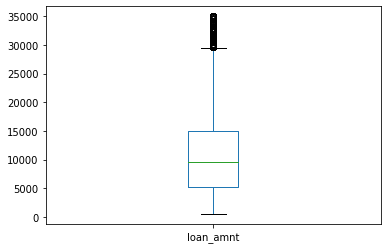

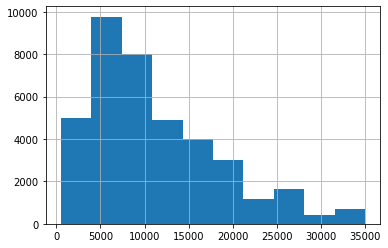

Number of Outlier according to IQR :- 2.820333359255515 %
count    38577.000000
mean     11047.025430
std       7348.441646
min        500.000000
25%       5300.000000
50%       9600.000000
75%      15000.000000
max      35000.000000
Name: loan_amnt, dtype: float64
------------------------------------
------------------------------------
Univariate analysis for funded_amnt Variable.


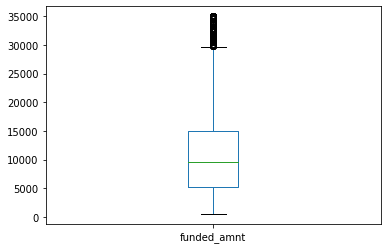

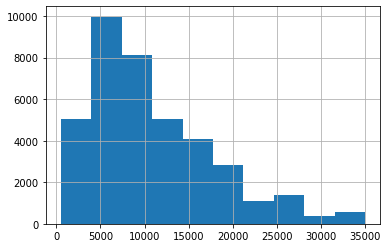

Number of Outlier according to IQR :- 2.3848407081940017 %
count    38577.000000
mean     10784.058506
std       7090.306027
min        500.000000
25%       5200.000000
50%       9550.000000
75%      15000.000000
max      35000.000000
Name: funded_amnt, dtype: float64
------------------------------------
------------------------------------
Univariate analysis for funded_amnt_inv Variable.


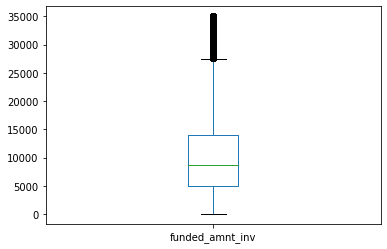

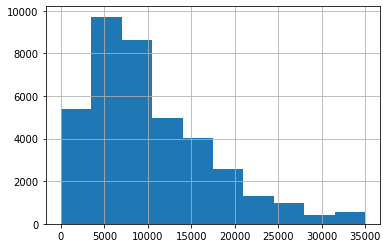

Number of Outlier according to IQR :- 2.6803535785571713 %
count    38577.000000
mean     10222.481123
std       7022.720644
min          0.000000
25%       5000.000000
50%       8733.440000
75%      14000.000000
max      35000.000000
Name: funded_amnt_inv, dtype: float64
------------------------------------
------------------------------------
Univariate analysis for int_rate Variable.


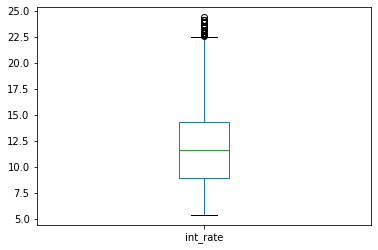

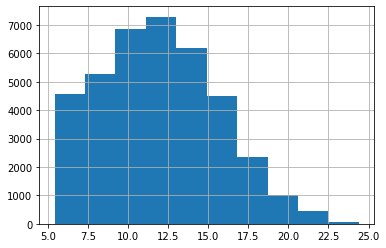

Number of Outlier according to IQR :- 0.16849418047022838 %
count    38577.000000
mean        11.932219
std          3.691327
min          5.420000
25%          8.940000
50%         11.710000
75%         14.380000
max         24.400000
Name: int_rate, dtype: float64
------------------------------------
------------------------------------
Univariate analysis for installment Variable.


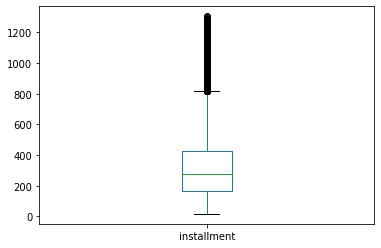

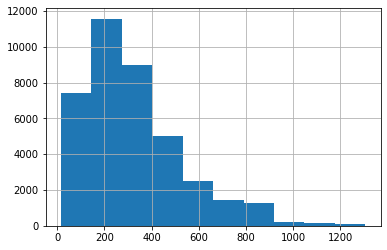

Number of Outlier according to IQR :- 3.559115535163439 %
count    38577.000000
mean       322.466318
std        208.639215
min         15.690000
25%        165.740000
50%        277.860000
75%        425.550000
max       1305.190000
Name: installment, dtype: float64
------------------------------------
------------------------------------
Univariate analysis for annual_inc Variable.


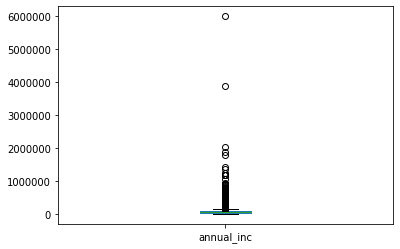

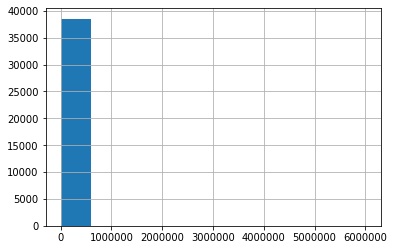

Number of Outlier according to IQR :- 4.567488399823729 %
count    3.857700e+04
mean     6.877797e+04
std      6.421868e+04
min      4.000000e+03
25%      4.000000e+04
50%      5.886800e+04
75%      8.200000e+04
max      6.000000e+06
Name: annual_inc, dtype: float64
------------------------------------
------------------------------------
Univariate analysis for dti Variable.


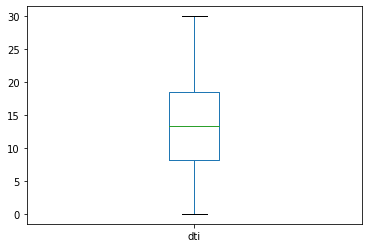

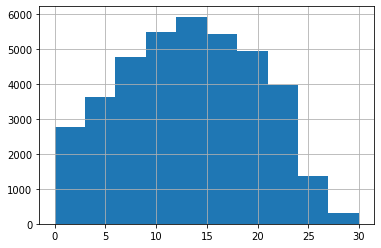

Number of Outlier according to IQR :- 0.0 %
count    38577.000000
mean        13.272727
std          6.673044
min          0.000000
25%          8.130000
50%         13.370000
75%         18.560000
max         29.990000
Name: dti, dtype: float64
------------------------------------
------------------------------------
Univariate analysis for delinq_2yrs Variable.


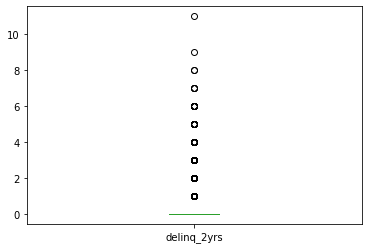

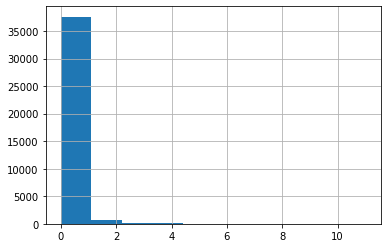

Number of Outlier according to IQR :- 10.863986313088109 %
count    38577.000000
mean         0.146668
std          0.492271
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         11.000000
Name: delinq_2yrs, dtype: float64
------------------------------------
------------------------------------
Univariate analysis for inq_last_6mths Variable.


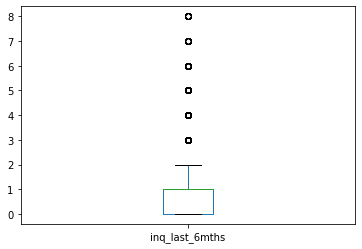

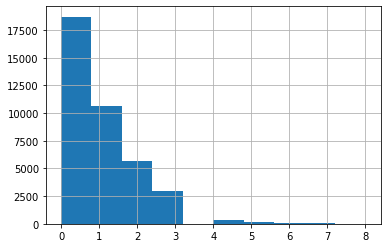

Number of Outlier according to IQR :- 9.212743344479872 %
count    38577.000000
mean         0.871737
std          1.071546
min          0.000000
25%          0.000000
50%          1.000000
75%          1.000000
max          8.000000
Name: inq_last_6mths, dtype: float64
------------------------------------
------------------------------------
Univariate analysis for mths_since_last_delinq Variable.


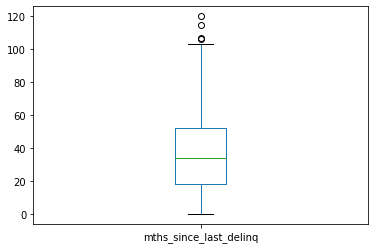

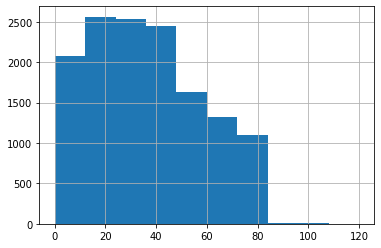

Number of Outlier according to IQR :- 0.0 %
count    13672.000000
mean        35.882534
std         22.028093
min          0.000000
25%         18.000000
50%         34.000000
75%         52.000000
max        120.000000
Name: mths_since_last_delinq, dtype: float64
------------------------------------
------------------------------------
Univariate analysis for open_acc Variable.


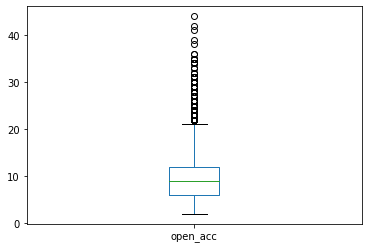

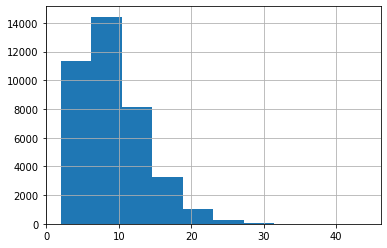

Number of Outlier according to IQR :- 1.2831479897348161 %
count    38577.000000
mean         9.275423
std          4.401588
min          2.000000
25%          6.000000
50%          9.000000
75%         12.000000
max         44.000000
Name: open_acc, dtype: float64
------------------------------------
------------------------------------
Univariate analysis for pub_rec Variable.


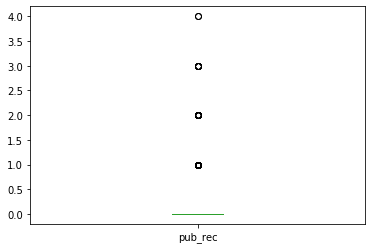

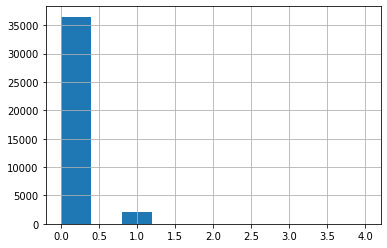

Number of Outlier according to IQR :- 5.365891593436504 %
count    38577.000000
mean         0.055422
std          0.237804
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          4.000000
Name: pub_rec, dtype: float64
------------------------------------
------------------------------------
Univariate analysis for revol_bal Variable.


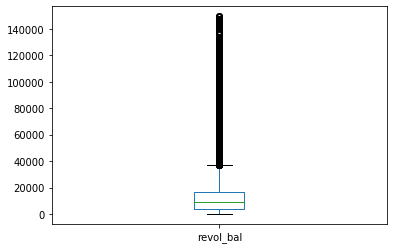

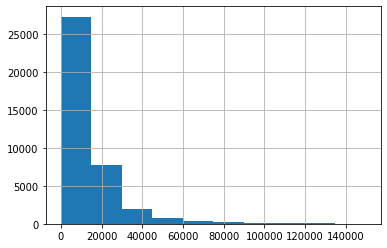

Number of Outlier according to IQR :- 6.280944604297898 %
count     38577.000000
mean      13289.489826
std       15866.492241
min           0.000000
25%        3650.000000
50%        8762.000000
75%       16912.000000
max      149588.000000
Name: revol_bal, dtype: float64
------------------------------------
------------------------------------
Univariate analysis for revol_util Variable.


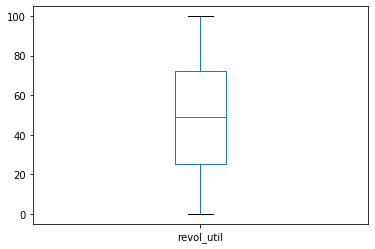

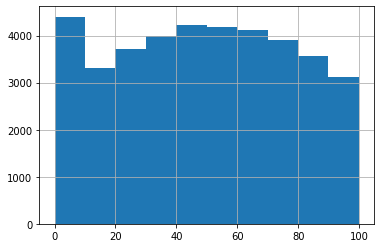

Number of Outlier according to IQR :- 0.0 %
count    38527.000000
mean        48.702777
std         28.364741
min          0.000000
25%         25.200000
50%         49.100000
75%         72.300000
max         99.900000
Name: revol_util, dtype: float64
------------------------------------
------------------------------------
Univariate analysis for total_acc Variable.


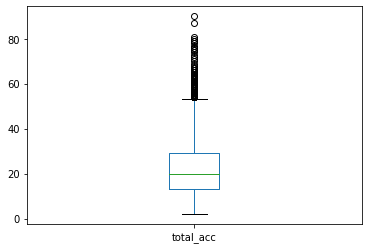

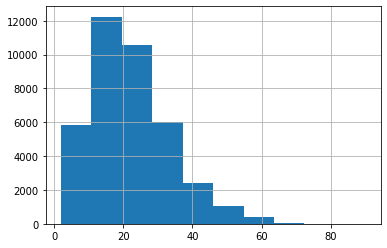

Number of Outlier according to IQR :- 1.329807916634264 %
count    38577.000000
mean        22.052648
std         11.425861
min          2.000000
25%         13.000000
50%         20.000000
75%         29.000000
max         90.000000
Name: total_acc, dtype: float64
------------------------------------
------------------------------------
Univariate analysis for pub_rec_bankruptcies Variable.


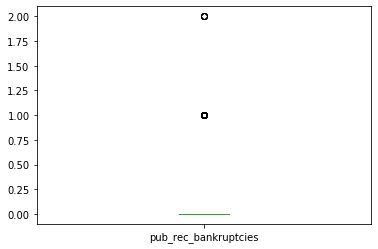

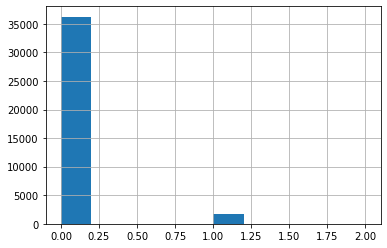

Number of Outlier according to IQR :- 0.0 %
count    37880.000000
mean         0.043479
std          0.204583
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          2.000000
Name: pub_rec_bankruptcies, dtype: float64


In [11]:
# For all the int data type plotting box plot and histogram to show the spread of the variables and mean,median,max,min,25%,75%.
# Dropping null variable of the variable while plotting the curve. :- This will taken care in plot function of pandas

# Not selecting id and member id
temp=Model_Building.columns[2:]
for i in temp:
    if Model_Building[i].dtypes in ['int64',float]:
        print("------------------------------------")
        print("------------------------------------")
        print("Univariate analysis for "+i+" Variable.")
        Model_Building[i].plot(kind="box")
        plt.show()
        Model_Building[i].hist()
        plt.show()
        q3, q1 = np.percentile(Model_Building[i], [75 ,25])
        iqr = q3 - q1
        upr=q3 + (1.5 * iqr)
        lwr=q1 - (1.5 * iqr)
        print("Number of Outlier according to IQR :- "+str((sum((Model_Building[i]<lwr) | (Model_Building[i]>upr)))*100/len(Model_Building)),"%")
        print(Model_Building[i].describe())

------------------------------------
------------------------------------
Univariate analysis for term Variable.


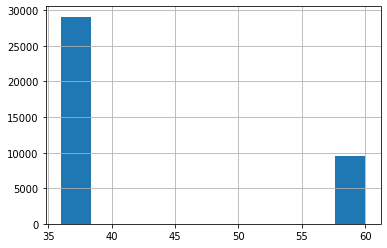

count    38577.000000
mean        41.898437
std         10.333136
min         36.000000
25%         36.000000
50%         36.000000
75%         36.000000
max         60.000000
Name: term, dtype: float64
------------------------------------
------------------------------------
Univariate analysis for grade Variable.


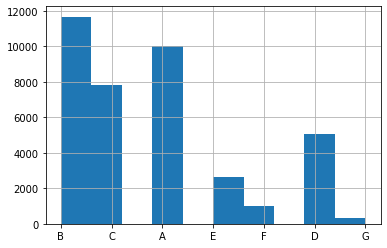

count     38577
unique        7
top           B
freq      11675
Name: grade, dtype: object
------------------------------------
------------------------------------
Univariate analysis for sub_grade Variable.


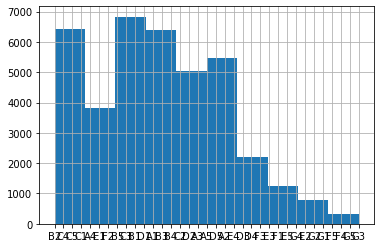

count     38577
unique       35
top          A4
freq       2873
Name: sub_grade, dtype: object
------------------------------------
------------------------------------
Univariate analysis for emp_length Variable.


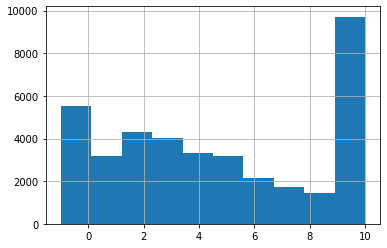

count    38577.000000
mean         4.781891
std          3.637835
min         -1.000000
25%          2.000000
50%          4.000000
75%          9.000000
max         10.000000
Name: emp_length, dtype: float64
------------------------------------
------------------------------------
Univariate analysis for home_ownership Variable.


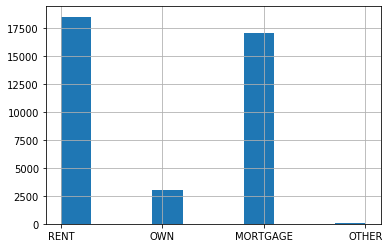

count     38577
unique        4
top        RENT
freq      18480
Name: home_ownership, dtype: object
------------------------------------
------------------------------------
Univariate analysis for verification_status Variable.


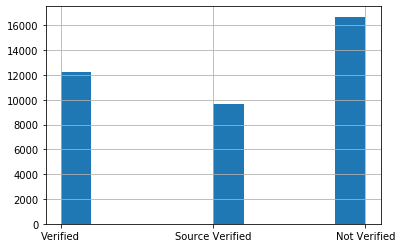

count            38577
unique               3
top       Not Verified
freq             16694
Name: verification_status, dtype: object
------------------------------------
------------------------------------
Univariate analysis for issue_d Variable.


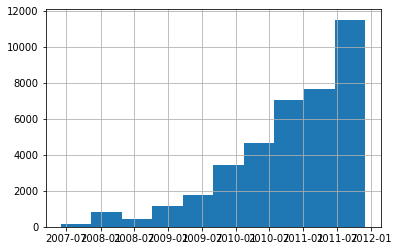

count                   38577
unique                     55
top       2011-11-01 00:00:00
freq                     2062
first     2007-06-01 00:00:00
last      2011-12-01 00:00:00
Name: issue_d, dtype: object
------------------------------------
------------------------------------
Univariate analysis for loan_status Variable.


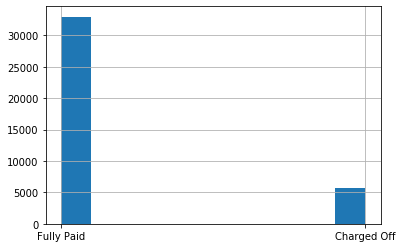

count          38577
unique             2
top       Fully Paid
freq           32950
Name: loan_status, dtype: object
------------------------------------
------------------------------------
Univariate analysis for purpose Variable.


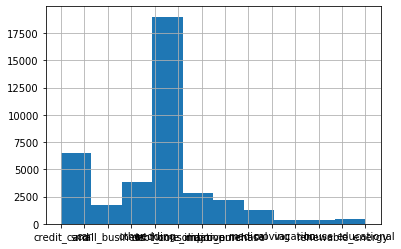

count                  38577
unique                    14
top       debt_consolidation
freq                   18055
Name: purpose, dtype: object
------------------------------------
------------------------------------
Univariate analysis for zip_code Variable.


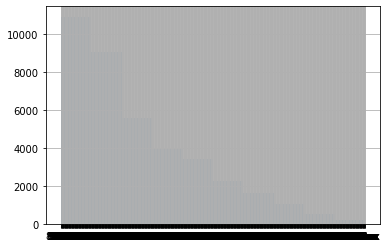

count     38577
unique      822
top       100xx
freq        583
Name: zip_code, dtype: object
------------------------------------
------------------------------------
Univariate analysis for addr_state Variable.


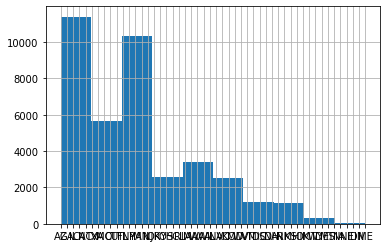

count     38577
unique       50
top          CA
freq       6949
Name: addr_state, dtype: object
------------------------------------
------------------------------------
Univariate analysis for earliest_cr_line Variable.


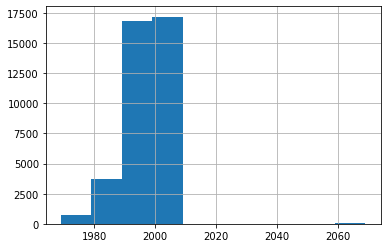

count                   38577
unique                    524
top       1999-10-01 00:00:00
freq                      360
first     1969-02-01 00:00:00
last      2068-12-01 00:00:00
Name: earliest_cr_line, dtype: object
------------------------------------
------------------------------------
Univariate analysis for last_credit_pull_d Variable.


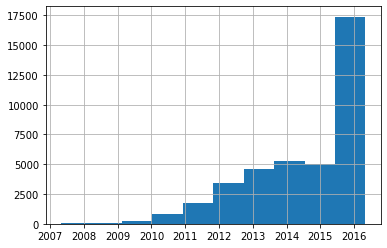

count                   38575
unique                    106
top       2016-05-01 00:00:00
freq                     9333
first     2007-05-01 00:00:00
last      2016-05-01 00:00:00
Name: last_credit_pull_d, dtype: object


In [12]:
# For all the Categorical data type plotting histogram to show the spread of the variables on individual variables.
temp=Model_Building.columns[2:]
for i in temp:
    if Model_Building[i].dtypes not in ['int64',float]:
        print("------------------------------------")
        print("------------------------------------")
        print("Univariate analysis for "+i+" Variable.")
        Model_Building[i].hist()
        plt.show()
        print(Model_Building[i].describe())

# Bivariate Analysis

--------------------------------------------------------------------
Bivariate Analysis for loan_amnt
--------------------------------------------------------------------


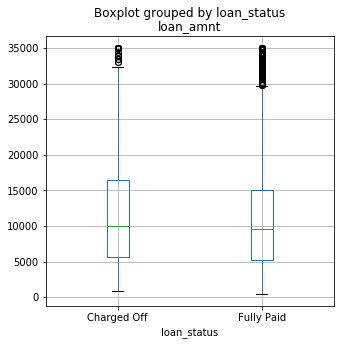

               count          mean          std    min     25%      50%  \
loan_status                                                               
Charged Off   5627.0  12104.385108  8085.732038  900.0  5600.0  10000.0   
Fully Paid   32950.0  10866.455994  7199.629493  500.0  5200.0   9600.0   

                 75%      max  
loan_status                    
Charged Off  16500.0  35000.0  
Fully Paid   15000.0  35000.0  
F_onewayResult(statistic=136.8774729093482, pvalue=1.4503293563965063e-31)
As p value is low specify there is difference between groups. Hence this variable is important

in predicting whether a customer will default or not
--------------------------------------------------------------------
Bivariate Analysis for funded_amnt
--------------------------------------------------------------------


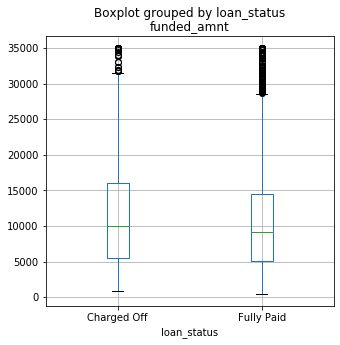

               count          mean          std    min     25%      50%  \
loan_status                                                               
Charged Off   5627.0  11753.398792  7760.516335  900.0  5575.0  10000.0   
Fully Paid   32950.0  10618.520486  6956.047888  500.0  5050.0   9200.0   

                 75%      max  
loan_status                    
Charged Off  16000.0  35000.0  
Fully Paid   14500.0  35000.0  
F_onewayResult(statistic=123.52353549522752, pvalue=1.1840458142380587e-28)
As p value is low specify there is difference between groups. Hence this variable is important

in predicting whether a customer will default or not
--------------------------------------------------------------------
Bivariate Analysis for funded_amnt_inv
--------------------------------------------------------------------


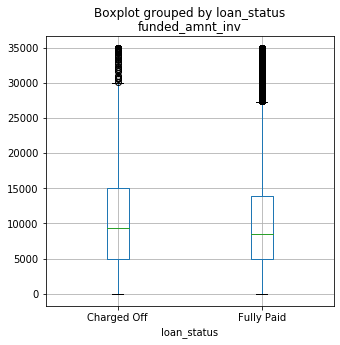

               count          mean          std  min     25%          50%  \
loan_status                                                                 
Charged Off   5627.0  10864.521324  7661.750540  0.0  5000.0  9401.209477   
Fully Paid   32950.0  10112.837414  6901.840874  0.0  5000.0  8500.000000   

                 75%      max  
loan_status                    
Charged Off  15000.0  35000.0  
Fully Paid   13950.0  35000.0  
F_onewayResult(statistic=55.140754300446254, pvalue=1.1451201545204338e-13)
As p value is low specify there is difference between groups. Hence this variable is important

in predicting whether a customer will default or not
--------------------------------------------------------------------
Bivariate Analysis for term
--------------------------------------------------------------------


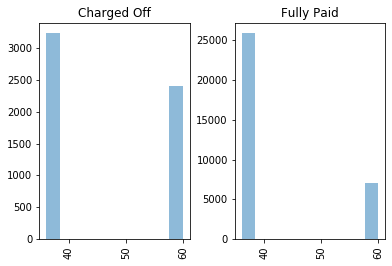

                   id                    
term               36        60       All
loan_status                              
Charged Off  0.110909  0.253138  0.145864
Fully Paid   0.889091  0.746862  0.854136
All          1.000000  1.000000  1.000000
p value is 7.507808214735614e-253
As p value is low specify there is difference between groups. Hence this variable is important

in predicting whether a customer will default or not
--------------------------------------------------------------------
Bivariate Analysis for int_rate
--------------------------------------------------------------------


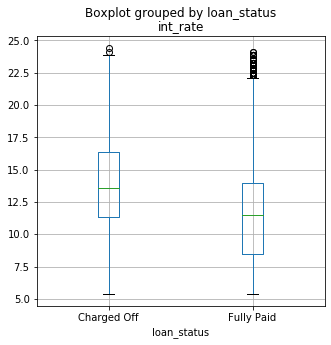

               count       mean       std   min    25%    50%    75%    max
loan_status                                                                
Charged Off   5627.0  13.820432  3.654413  5.42  11.31  13.61  16.40  24.40
Fully Paid   32950.0  11.609761  3.599964  5.42   8.49  11.49  13.99  24.11
F_onewayResult(statistic=1804.3856568327715, pvalue=0.0)
As p value is low specify there is difference between groups. Hence this variable is important

in predicting whether a customer will default or not
--------------------------------------------------------------------
Bivariate Analysis for installment
--------------------------------------------------------------------


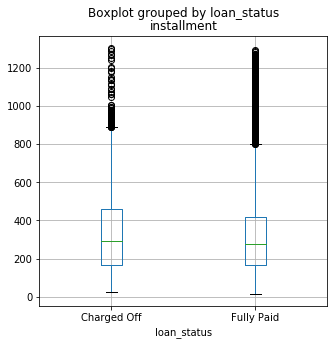

               count        mean         std    min       25%     50%  \
loan_status                                                             
Charged Off   5627.0  336.175006  217.051841  22.79  168.5550  293.87   
Fully Paid   32950.0  320.125232  207.081110  15.69  165.2825  275.65   

                 75%      max  
loan_status                    
Charged Off  457.840  1305.19  
Fully Paid   420.735  1295.21  
F_onewayResult(statistic=28.461574615819565, pvalue=9.61144527879393e-08)
As p value is low specify there is difference between groups. Hence this variable is important

in predicting whether a customer will default or not
--------------------------------------------------------------------
Bivariate Analysis for grade
--------------------------------------------------------------------


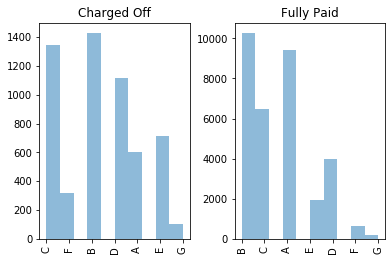

                  id                                                    \
grade              A         B         C         D         E         F   
loan_status                                                              
Charged Off  0.05993  0.122056  0.171943  0.219862  0.268494  0.326844   
Fully Paid   0.94007  0.877944  0.828057  0.780138  0.731506  0.673156   
All          1.00000  1.000000  1.000000  1.000000  1.000000  1.000000   

                                 
grade               G       All  
loan_status                      
Charged Off  0.337793  0.145864  
Fully Paid   0.662207  0.854136  
All          1.000000  1.000000  
p value is 0.0
As p value is low specify there is difference between groups. Hence this variable is important

in predicting whether a customer will default or not
--------------------------------------------------------------------
Bivariate Analysis for emp_length
--------------------------------------------------------------------


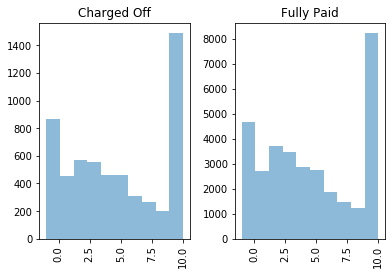

                   id                                                    \
emp_length         -1         0         1         2         3         4   
loan_status                                                               
Charged Off  0.220716  0.141748  0.143894  0.132137  0.138335  0.138241   
Fully Paid   0.779284  0.858252  0.856106  0.867863  0.861665  0.861759   
All          1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   

                                                                        \
emp_length          5         6         7         8         9       10   
loan_status                                                              
Charged Off  0.143394  0.141605  0.153711  0.141463  0.128874  0.15681   
Fully Paid   0.856606  0.858395  0.846289  0.858537  0.871126  0.84319   
All          1.000000  1.000000  1.000000  1.000000  1.000000  1.00000   

                       
emp_length        All  
loan_status            
Charged Off  0.145864  
Fully Pa

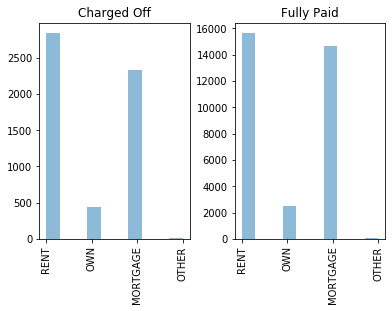

                      id                                        
home_ownership  MORTGAGE     OTHER       OWN      RENT       All
loan_status                                                     
Charged Off     0.136713  0.178218  0.148908  0.153626  0.145864
Fully Paid      0.863287  0.821782  0.851092  0.846374  0.854136
All             1.000000  1.000000  1.000000  1.000000  1.000000
p value is 0.00025843558833765903
As p value is low specify there is difference between groups. Hence this variable is important

in predicting whether a customer will default or not
--------------------------------------------------------------------
Bivariate Analysis for annual_inc
--------------------------------------------------------------------


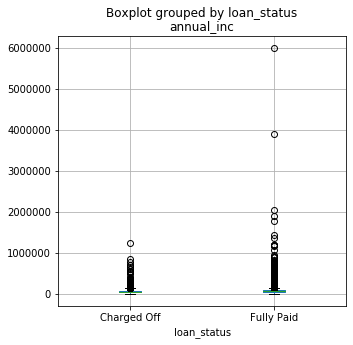

               count          mean           std     min       25%      50%  \
loan_status                                                                   
Charged Off   5627.0  62427.298034  47776.014188  4080.0  37000.00  53000.0   
Fully Paid   32950.0  69862.503328  66562.246521  4000.0  41132.75  60000.0   

                 75%        max  
loan_status                      
Charged Off  75000.0  1250000.0  
Fully Paid   84000.0  6000000.0  
F_onewayResult(statistic=64.5329790413677, pvalue=9.760512885668242e-16)
As p value is low specify there is difference between groups. Hence this variable is important

in predicting whether a customer will default or not
--------------------------------------------------------------------
Bivariate Analysis for verification_status
--------------------------------------------------------------------


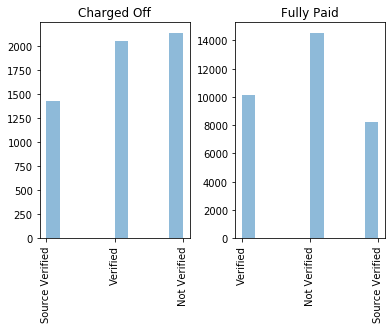

                              id                                    
verification_status Not Verified Source Verified  Verified       All
loan_status                                                         
Charged Off              0.12831        0.148186  0.168032  0.145864
Fully Paid               0.87169        0.851814  0.831968  0.854136
All                      1.00000        1.000000  1.000000  1.000000
p value is 2.352625840373299e-19
As p value is low specify there is difference between groups. Hence this variable is important

in predicting whether a customer will default or not
--------------------------------------------------------------------
Bivariate Analysis for purpose
--------------------------------------------------------------------


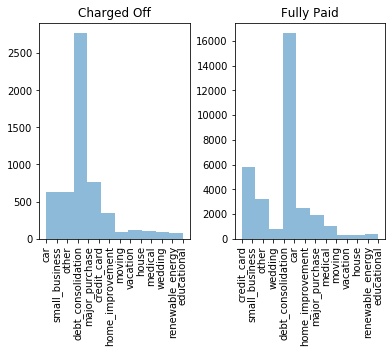

                   id                                             \
purpose           car credit_card debt_consolidation educational   
loan_status                                                        
Charged Off  0.106738    0.107818           0.153254    0.172308   
Fully Paid   0.893262    0.892182           0.846746    0.827692   
All          1.000000    1.000000           1.000000    1.000000   

                                                                           \
purpose     home_improvement     house major_purchase   medical    moving   
loan_status                                                                 
Charged Off         0.120696  0.160763       0.103256  0.155653  0.159722   
Fully Paid          0.879304  0.839237       0.896744  0.844347  0.840278   
All                 1.000000  1.000000       1.000000  1.000000  1.000000   

                                                                           \
purpose         other renewable_energy small_busine

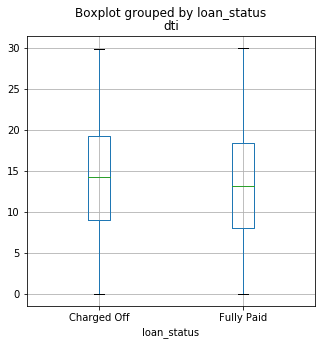

               count       mean       std  min   25%    50%    75%    max
loan_status                                                              
Charged Off   5627.0  14.000624  6.585577  0.0  9.05  14.29  19.29  29.85
Fully Paid   32950.0  13.148421  6.680041  0.0  7.98  13.20  18.39  29.99
F_onewayResult(statistic=78.5441124815935, pvalue=8.150080542906613e-19)
As p value is low specify there is difference between groups. Hence this variable is important

in predicting whether a customer will default or not
--------------------------------------------------------------------
Bivariate Analysis for delinq_2yrs
--------------------------------------------------------------------


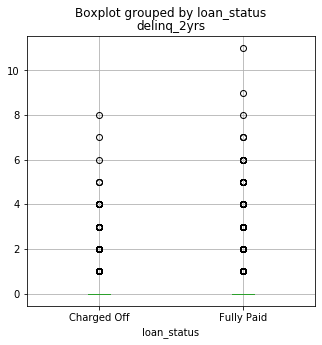

               count      mean       std  min  25%  50%  75%   max
loan_status                                                       
Charged Off   5627.0  0.170606  0.534986  0.0  0.0  0.0  0.0   8.0
Fully Paid   32950.0  0.142580  0.484491  0.0  0.0  0.0  0.0  11.0
F_onewayResult(statistic=15.584474612305476, pvalue=7.903966337022813e-05)
As p value is low specify there is difference between groups. Hence this variable is important

in predicting whether a customer will default or not
--------------------------------------------------------------------
Bivariate Analysis for inq_last_6mths
--------------------------------------------------------------------


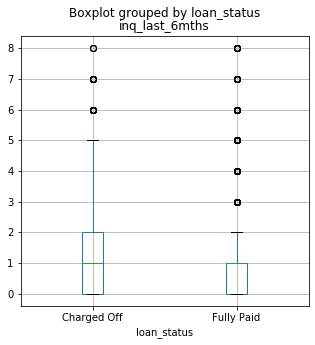

               count      mean       std  min  25%  50%  75%  max
loan_status                                                      
Charged Off   5627.0  1.058113  1.154136  0.0  0.0  1.0  2.0  8.0
Fully Paid   32950.0  0.839909  1.053524  0.0  0.0  1.0  1.0  8.0
F_onewayResult(statistic=200.32958798609204, pvalue=2.299307432774849e-45)
As p value is low specify there is difference between groups. Hence this variable is important

in predicting whether a customer will default or not
--------------------------------------------------------------------
Bivariate Analysis for mths_since_last_delinq
--------------------------------------------------------------------


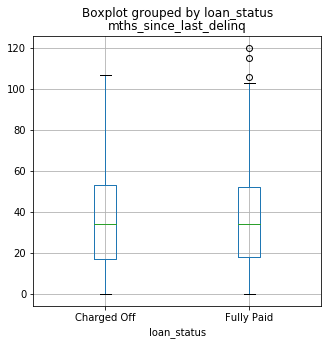

               count       mean        std  min   25%   50%   75%    max
loan_status                                                             
Charged Off   2142.0  36.157330  22.679333  0.0  17.0  34.0  53.0  107.0
Fully Paid   11530.0  35.831483  21.905603  0.0  18.0  34.0  52.0  120.0
F_onewayResult(statistic=0.3952481656517015, pvalue=0.5295640669275665)
As p value is high specify there is no between groups. Hence this variable is not important

in predicting whether a customer will default or not
--------------------------------------------------------------------
Bivariate Analysis for open_acc
--------------------------------------------------------------------


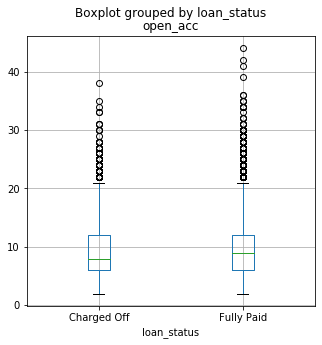

               count      mean       std  min  25%  50%   75%   max
loan_status                                                        
Charged Off   5627.0  9.178070  4.525937  2.0  6.0  8.0  12.0  38.0
Fully Paid   32950.0  9.292049  4.379854  2.0  6.0  9.0  12.0  44.0
F_onewayResult(statistic=3.2229698752192077, pvalue=0.07261960351918773)
As p value is high specify there is no between groups. Hence this variable is not important

in predicting whether a customer will default or not
--------------------------------------------------------------------
Bivariate Analysis for pub_rec
--------------------------------------------------------------------


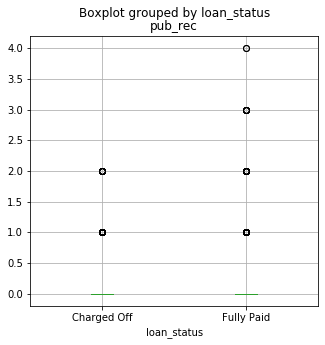

               count     mean       std  min  25%  50%  75%  max
loan_status                                                     
Charged Off   5627.0  0.08477  0.284873  0.0  0.0  0.0  0.0  2.0
Fully Paid   32950.0  0.05041  0.228429  0.0  0.0  0.0  0.0  4.0
F_onewayResult(statistic=100.59909168862964, pvalue=1.2039570694326106e-23)
As p value is low specify there is difference between groups. Hence this variable is important

in predicting whether a customer will default or not
--------------------------------------------------------------------
Bivariate Analysis for revol_bal
--------------------------------------------------------------------


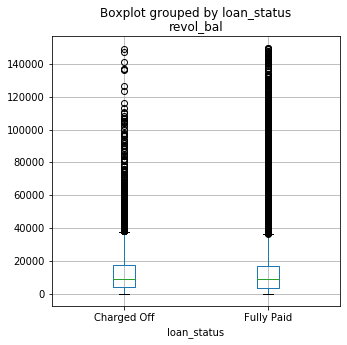

               count          mean           std  min     25%     50%  \
loan_status                                                             
Charged Off   5627.0  13514.243647  15164.117475  0.0  3968.0  9211.0   
Fully Paid   32950.0  13251.107739  15983.260153  0.0  3603.0  8682.5   

                  75%       max  
loan_status                      
Charged Off  17518.00  148829.0  
Fully Paid   16804.75  149588.0  
F_onewayResult(statistic=1.3219221888983423, pvalue=0.2502544970962192)
As p value is high specify there is no between groups. Hence this variable is not important

in predicting whether a customer will default or not
--------------------------------------------------------------------
Bivariate Analysis for revol_util
--------------------------------------------------------------------


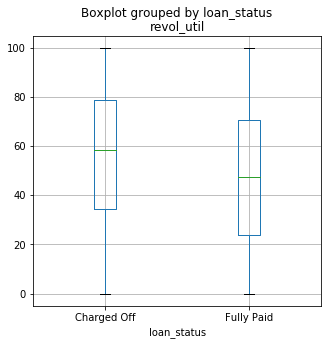

               count       mean        std  min   25%   50%   75%   max
loan_status                                                            
Charged Off   5611.0  55.572110  27.905282  0.0  34.4  58.4  79.0  99.9
Fully Paid   32916.0  47.531801  28.276743  0.0  23.9  47.6  70.8  99.9
F_onewayResult(statistic=389.0654183353784, pvalue=3.5259163449641125e-86)
As p value is low specify there is difference between groups. Hence this variable is important

in predicting whether a customer will default or not
--------------------------------------------------------------------
Bivariate Analysis for total_acc
--------------------------------------------------------------------


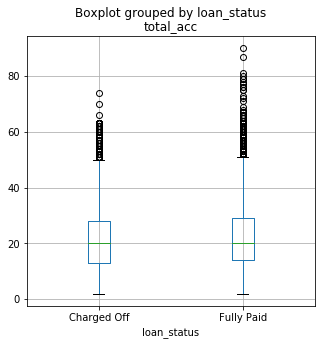

               count       mean        std  min   25%   50%   75%   max
loan_status                                                            
Charged Off   5627.0  21.427581  11.447427  2.0  13.0  20.0  28.0  74.0
Fully Paid   32950.0  22.159393  11.418927  2.0  14.0  20.0  29.0  90.0
F_onewayResult(statistic=19.725840509352658, pvalue=8.963264009052628e-06)
As p value is low specify there is difference between groups. Hence this variable is important

in predicting whether a customer will default or not
--------------------------------------------------------------------
Bivariate Analysis for pub_rec_bankruptcies
--------------------------------------------------------------------


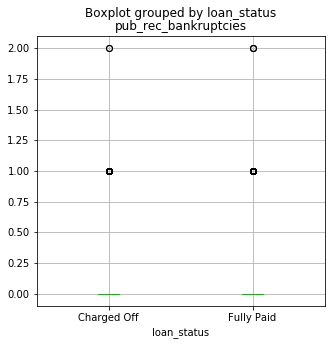

               count      mean       std  min  25%  50%  75%  max
loan_status                                                      
Charged Off   5509.0  0.067163  0.251773  0.0  0.0  0.0  0.0  2.0
Fully Paid   32371.0  0.039449  0.195139  0.0  0.0  0.0  0.0  2.0
F_onewayResult(statistic=86.58806706417435, pvalue=1.4058016977543636e-20)
As p value is low specify there is difference between groups. Hence this variable is important

in predicting whether a customer will default or not


In [13]:
# categorical to categorical comparision we are using chi square test for checking whether two groups are different or not
# for Categorical to continous comparision we are using one way anova for checking the difference in mean for all the groups
# if we are having any missing value in categorical variable we are remove it in below analysis.
# not including coluns with many values and date variable in below analysis.
# sub_grade, issue_d, zip_code, addr_state, earliest_cr_line, last_credit_pull_d

df=pd.DataFrame(columns=['Variable_Name','P_Value'])
z=0
for i in ['loan_amnt', 'funded_amnt', 'funded_amnt_inv',
       'term', 'int_rate', 'installment', 'grade', 'emp_length',
       'home_ownership', 'annual_inc', 'verification_status',
       'purpose', 'dti',
       'delinq_2yrs', 'inq_last_6mths',
       'mths_since_last_delinq', 'open_acc', 'pub_rec', 'revol_bal',
       'revol_util', 'total_acc', 'pub_rec_bankruptcies']:
    print("--------------------------------------------------------------------")
    print("Bivariate Analysis for "+ str(i))
    print("--------------------------------------------------------------------")
    if Model_Building[i].dtypes in ['int64',float]:
        tmp=Model_Building[[i,'loan_status']]
        tmp=tmp[tmp[i].isnull()==False]
        tmp.reset_index(drop=True,inplace=True)
        tmp.boxplot(i, by='loan_status', figsize=(5, 5))
        plt.show()
        print(tmp.groupby(['loan_status'])[i].describe())
        print(f_oneway(tmp[tmp['loan_status']=='Charged Off'][i], tmp[tmp['loan_status']!='Charged Off'][i]))
        df.at[z,:]=[i,f_oneway(tmp[tmp['loan_status']=='Charged Off'][i], tmp[tmp['loan_status']!='Charged Off'][i])[1]]
        p=f_oneway(tmp[tmp['loan_status']=='Charged Off'][i], tmp[tmp['loan_status']!='Charged Off'][i])[1]
    else:
        Model_Building.hist(column=i,by="loan_status",alpha=0.5)
        plt.show()
        base_mtrx = Model_Building.pivot_table(index =['loan_status'],values =['id'],columns=[i],aggfunc ='count',margins=True)
        print(base_mtrx.div(base_mtrx.iloc[2],axis=1))
        data = [list(base_mtrx.iloc[0]), list(base_mtrx.iloc[1])]
        stat, p, dof, expected = chi2_contingency(data)
        print("p value is " + str(p))
        df.at[z,:]=[i,p]
    if (p<=0.05):
        print("""As p value is low specify there is difference between groups. Hence this variable is important\n
in predicting whether a customer will default or not""")
    else:
        print("""As p value is high specify there is no between groups. Hence this variable is not important\n
in predicting whether a customer will default or not""")
    z+=1
        

In [14]:
df

,Variable_Name,P_Value
0,loan_amnt,1.45033e-31
1,funded_amnt,1.18405e-28
2,funded_amnt_inv,1.14512e-13
3,term,7.50781e-253
4,int_rate,0
5,installment,9.61145e-08
6,grade,0
7,emp_length,3.83018e-10
8,home_ownership,0.000258436
9,annual_inc,9.76051e-16


# Results of simple Uni-Variate and Bi-Variate analysis

###### Univariate analysis
1. According to IQR almost all the Continuous column have less than 10% of outliers.
2. Most of the customer belongs to CA State(18%).
3. Last credit pull is 2016 for 37% of the total base.
4. For customer coming to lending club almost 47% of the customer purpose of taking loan is debt_consolidation.
5. Disbursement is increasing year on year from 2007 to 2011. In 2011 53% of total disbursement happens.
6. We have verified income for almost 57% of the total customers.
7. According to our customer almost 89% customer owns a property or have a mortgage loan on them.
8. Almost 22% of the total customer have a employment length of 10 or 10+ years.
9. A4, B3, A5 are the most sold subgrade of loan category.
10. B,A,C are the most sold grade of the loan.
11. 75% of the total customer takes short term loan of 36 months.
12. Median loan_amount ask by the customer is 9600.
13. Median funded_amount suggested by lending club is 9550.
14. Median amount funded by investor is 8733.
15. Average intereset rate charge by the company is 11-12%.
16. Average installment is 255 per month.
17. Median anual income of the customer base is 58000.
18. dti is normally distributed accross customer.
19. for most of the customer delinq_2yrs is 0.
20. almost 50% of the population does 0 inquiry in last 6 months.

###### Bivariate analysis
1. mths_since_last_delinq, open_acc, revol_bal are not related to event variable and they have very less p value.
2. term has the highest impact on loan_status. but it has only two value and we can'not recommend bank to give only 36 or 60 months loan. (either one).
3. Higher the ask of loan_amnt higher chances of default same with funded amount and invested amount.
4. Higher term customers tends to default more.
5. Customer having higher int rate tends to default more. Higher int rate given to those customer who have high chance of default. This is moving in the correct direction.
6. G grade have the highest default rate.
7. People having missing emp length have more default rate.
8. Home ownership having value as other tends to default more.
9. Higher the income tends to default less.
10. Verfied income salary people tends to default more. Reason can be non verified income employee come from small business background.
11. People taking loan for education tends to default more.
12. higher dti higher chances to default more.
13. Higher the 2 year delinquence higher chances of default.
14. High inquiry higher chances of default.
15. Higher number of open account lower the chance of default. Knows how to handle money. same with total number of loans.
16. Higher Number of public record bankruptcies higher chances of default.

---------------------------------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------------------------------

In [15]:
# Dropping all the variables having p value greater than .05 and including variables which have highest variablity. And doing deep down analysis
df=df[df['P_Value']<=0.05]
df.reset_index(drop=True,inplace=True)
print(df)

           Variable_Name       P_Value
0              loan_amnt   1.45033e-31
1            funded_amnt   1.18405e-28
2        funded_amnt_inv   1.14512e-13
3                   term  7.50781e-253
4               int_rate             0
5            installment   9.61145e-08
6                  grade             0
7             emp_length   3.83018e-10
8         home_ownership   0.000258436
9             annual_inc   9.76051e-16
10   verification_status   2.35263e-19
11               purpose   3.42928e-72
12                   dti   8.15008e-19
13           delinq_2yrs   7.90397e-05
14        inq_last_6mths   2.29931e-45
15               pub_rec   1.20396e-23
16            revol_util   3.52592e-86
17             total_acc   8.96326e-06
18  pub_rec_bankruptcies    1.4058e-20


In [16]:
final_Variables=list(df['Variable_Name'])
final_Variables.extend(['sub_grade', 'issue_d', 'zip_code', 'addr_state', 'earliest_cr_line', 'last_credit_pull_d'])
final_Variables.extend(['member_id','id','loan_status'])

In [17]:
Model_Building=Model_Building[final_Variables]

In [18]:
Model_Building.isnull().sum()

loan_amnt                 0
funded_amnt               0
funded_amnt_inv           0
term                      0
int_rate                  0
installment               0
grade                     0
emp_length                0
home_ownership            0
annual_inc                0
verification_status       0
purpose                   0
dti                       0
delinq_2yrs               0
inq_last_6mths            0
pub_rec                   0
revol_util               50
total_acc                 0
pub_rec_bankruptcies    697
sub_grade                 0
issue_d                   0
zip_code                  0
addr_state                0
earliest_cr_line          0
last_credit_pull_d        2
member_id                 0
id                        0
loan_status               0
dtype: int64

In [19]:
# Filling missing values

# As mean and median value are very close by filling with median value
print(Model_Building['revol_util'].describe())
Model_Building['revol_util'].fillna(Model_Building['revol_util'].median(),inplace=True)

# As till 75 percentile value is 0 filling with 0
print(Model_Building['pub_rec_bankruptcies'].describe())
Model_Building['pub_rec_bankruptcies'].fillna(0,inplace=True)

# as 25% data last_credit_pull_d is 2016-05-01 same as maximum date. Filling missing with this value
print(Model_Building['last_credit_pull_d'].value_counts(normalize=True))
print(max(Model_Building['last_credit_pull_d']))
Model_Building['last_credit_pull_d'].fillna(max(Model_Building['last_credit_pull_d']),inplace=True)

count    38527.000000
mean        48.702777
std         28.364741
min          0.000000
25%         25.200000
50%         49.100000
75%         72.300000
max         99.900000
Name: revol_util, dtype: float64
count    37880.000000
mean         0.043479
std          0.204583
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          2.000000
Name: pub_rec_bankruptcies, dtype: float64
2016-05-01    0.241944
2016-04-01    0.062035
2016-03-01    0.029086
2013-02-01    0.021854
2016-02-01    0.019002
                ...   
2008-06-01    0.000026
2007-05-01    0.000026
2008-07-01    0.000026
2008-05-01    0.000026
2007-07-01    0.000026
Name: last_credit_pull_d, Length: 106, dtype: float64
2016-05-01 00:00:00


In [20]:
# Changing event to 0 and 1.
Model_Building['loan_status']=np.where(Model_Building['loan_status']=="Fully Paid",0,1)

In [21]:
print(Model_Building['loan_status'].value_counts(normalize=True))

0    0.854136
1    0.145864
Name: loan_status, dtype: float64


In [22]:
# Creating business logic variables

# How old customer is related to bureau
Model_Building['Bureau_Vintage']=(((Model_Building['issue_d']).dt.year-(Model_Building['earliest_cr_line']).dt.year)*12)+((Model_Building['issue_d']).dt.month-(Model_Building['earliest_cr_line']).dt.month)
# Making 0 for all the months getting -ve values
# As bureau can not be negative
# user have taken loan from us and we haven't reported in the bureau this is called as bureau lag
# we are incorporating it now and making 0 for all the -ve values.
Model_Building['Bureau_Vintage']=np.where(Model_Building['Bureau_Vintage']<=0,0,Model_Building['Bureau_Vintage'])

# Customer bureau pull from issue date date in months 
Model_Building['Pulled_Issue_Months']=(((Model_Building['last_credit_pull_d']).dt.year-(Model_Building['issue_d']).dt.year)*12)+((Model_Building['last_credit_pull_d']).dt.month-(Model_Building['issue_d']).dt.month)
print(sum(Model_Building['Pulled_Issue_Months']<0))
print(Model_Building[Model_Building['Pulled_Issue_Months']<0]['loan_status'].value_counts())
# As all the records having buearu pull date before issue date loan status is 0 that means they haven't pulled because they haven't defaulted.
# Dropping these records.
Model_Building=Model_Building[Model_Building['Pulled_Issue_Months']>=0]
Model_Building.reset_index(drop=True,inplace=True)
Model_Building.drop(['issue_d','earliest_cr_line','last_credit_pull_d'],inplace=True,axis=1)

35
0    35
Name: loan_status, dtype: int64


In [23]:
# Grouping Sub_grade according to event rates

print("Sub_Grade")
a=Model_Building.groupby(['sub_grade']).agg({'id':'count','loan_status':'sum'}).reset_index(drop=False)
a['Percentage']=a['loan_status']/a['id']
a['Sub_Grade_Bucket']=pd.cut(a['Percentage'],[-np.Inf,.1,.15,.2,.25,.3,np.Inf])
a.to_csv('Sub_Grade_Classification.csv',index=False)
Model_Building=Model_Building.merge(a[['sub_grade','Sub_Grade_Bucket']],on="sub_grade",how="left")
Model_Building.drop(['sub_grade'],inplace=True,axis=1)

# Grouping Zip_Code according to event rates
print("zip_code")
a=Model_Building.groupby(['zip_code']).agg({'id':'count','loan_status':'sum'}).reset_index(drop=False)
a['Percentage']=a['loan_status']/a['id']
a['zip_code_Bucket']=pd.cut(a['Percentage'],[-np.Inf,.05,.1,.15,.2,np.Inf])
a.to_csv('Zip_Code_Classification.csv',index=False)
Model_Building=Model_Building.merge(a[['zip_code','zip_code_Bucket']],on="zip_code",how="left")
Model_Building.drop(['zip_code'],inplace=True,axis=1)

# Grouping Addr_State according to event rates
print("addr_state")
a=Model_Building.groupby(['addr_state']).agg({'id':'count','loan_status':'sum'}).reset_index(drop=False)
a['Percentage']=a['loan_status']/a['id']
a['addr_state_Bucket']=pd.cut(a['Percentage'],[-np.Inf,.15,np.Inf])
a.to_csv('Address_State_Classification.csv',index=False)
Model_Building=Model_Building.merge(a[['addr_state','addr_state_Bucket']],on="addr_state",how="left")
Model_Building.drop(['addr_state'],inplace=True,axis=1)

Sub_Grade
zip_code
addr_state


In [24]:
Model_Building.columns

Index(['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term', 'int_rate',
       'installment', 'grade', 'emp_length', 'home_ownership', 'annual_inc',
       'verification_status', 'purpose', 'dti', 'delinq_2yrs',
       'inq_last_6mths', 'pub_rec', 'revol_util', 'total_acc',
       'pub_rec_bankruptcies', 'member_id', 'id', 'loan_status',
       'Bureau_Vintage', 'Pulled_Issue_Months', 'Sub_Grade_Bucket',
       'zip_code_Bucket', 'addr_state_Bucket'],
      dtype='object')

In [25]:
# Defining Information value function and woe for extracting importance of each variable.
def iv_woe(data, target, bins=10, show_woe=False):
    
    newDF = pd.DataFrame()
    woeDF = pd.DataFrame()
    
    cols = data.columns
    
    for ivars in cols[~cols.isin([target])]:
        if (data[ivars].dtype in ['int64',float]) and (len(np.unique(data[ivars]))>10):
            binned_x = pd.qcut(data[ivars], bins,  duplicates='drop')
            d0 = pd.DataFrame({'x': binned_x, 'y': data[target]})
        else:
            d0 = pd.DataFrame({'x': data[ivars], 'y': data[target]})
        d0['x'] = d0['x'].astype(str)
        d = d0.groupby("x", as_index=False).agg({"y": ["count", "sum"]})
        d.columns = ['Cutoff', 'N', 'Events']
        d['% of Events'] = np.maximum(d['Events'], 0.5) / d['Events'].sum()
        d['Non-Events'] = d['N'] - d['Events']
        d['% of Non-Events'] = np.maximum(d['Non-Events'], 0.5) / d['Non-Events'].sum()
        d['WoE'] = np.log(d['% of Non-Events']/d['% of Events'])
        d['IV'] = d['WoE'] * (d['% of Non-Events']-d['% of Events'])
        d.insert(loc=0, column='Variable', value=ivars)
        print("IV of " + ivars + " is " + str(round(d['IV'].sum(),6)))
        temp =pd.DataFrame({"Variable" : [ivars], "IV" : [d['IV'].sum()]}, columns = ["Variable", "IV"])
        newDF=pd.concat([newDF,temp], axis=0)
        woeDF=pd.concat([woeDF,d], axis=0)

        #Show WOE Table
        if show_woe == True:
            print(d)
    return newDF, woeDF

In [26]:
# Using information value for bucketing continuos variable in categorical variable.
# and finding importance of each variable.

iv, woe = iv_woe(data = Model_Building, target = 'loan_status', bins=10, show_woe = False)

IV of loan_amnt is 0.032718
IV of funded_amnt is 0.03344
IV of funded_amnt_inv is 0.027785
IV of term is 0.21114
IV of int_rate is 0.366384
IV of installment is 0.01118
IV of grade is 0.339222
IV of emp_length is 0.013005
IV of home_ownership is 0.004456
IV of annual_inc is 0.040866
IV of verification_status is 0.018404
IV of purpose is 0.072062
IV of dti is 0.0186
IV of delinq_2yrs is 0.002563
IV of inq_last_6mths is 0.044568
IV of pub_rec is 0.020055
IV of revol_util is 0.081952
IV of total_acc is 0.007802
IV of pub_rec_bankruptcies is 0.014892
IV of member_id is 0.021114
IV of id is 0.021542
IV of Bureau_Vintage is 0.010587
IV of Pulled_Issue_Months is 0.33708
IV of Sub_Grade_Bucket is 0.338109
IV of zip_code_Bucket is 0.212765
IV of addr_state_Bucket is 0.021339


In [27]:
iv.sort_values('IV',ascending=False)

,Variable,IV
0,int_rate,0.366384
0,grade,0.339222
0,Sub_Grade_Bucket,0.338109
0,Pulled_Issue_Months,0.337080
0,zip_code_Bucket,0.212765
0,term,0.211140
0,revol_util,0.081952
0,purpose,0.072062
0,inq_last_6mths,0.044568
0,annual_inc,0.040866


In [28]:
woe['Event_Percentage']=woe['Events']/woe['N']
woe['Cutoff_Min']=[float(re.sub("]","",(i.split(",")[1]).strip())) if len(i.split(","))>1 else i for i in woe['Cutoff']]

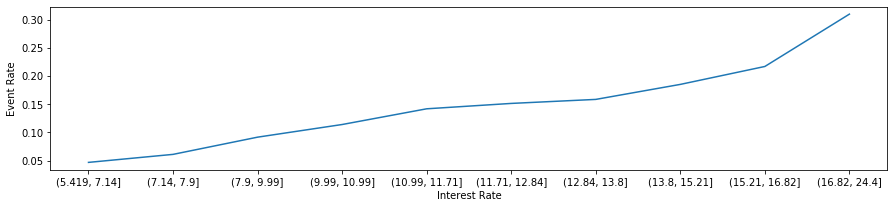

Indicating as interest rate increases Event increase
WOE is monotonically increasing


In [29]:
# Most important variable is coming as Int_Rate.
# But at the time of aquisition we give higher interest in two scenarios.
# 1. When customer is asking for more loan and we want to give the same amount but as per current process he/she is eligible for small ticket size.
# 2. When customer chances of default is little high as compare to other population.
# Now as we have already given the loan to customer, risk assessment which we have taken into consideration at the time of aquisition is holding true.

x=woe[woe['Variable']=="int_rate"].sort_values('WoE',ascending=False)['Cutoff']
y=woe[woe['Variable']=="int_rate"].sort_values('WoE',ascending=False)['Event_Percentage']
f = plt.figure()
f.set_figwidth(15)
f.set_figheight(3)
plt.xlabel('Interest Rate')
plt.ylabel('Event Rate')
plt.plot(x, y)
plt.show()
print("Indicating as interest rate increases Event increase")
print("WOE is monotonically increasing")

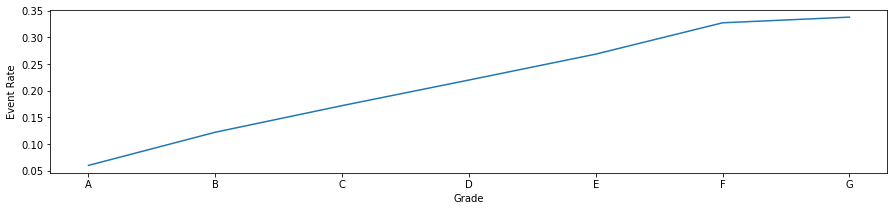

Indicating as grade move from A to G Event increase
WOE is monotonically decreasing


In [30]:
# Second Most important variable is coming as Grade.
# We can not take any call on grade specifically as its just a type of a loan.
# But at the time of collection we need to put more effort on grade 'G' customer as they have high chance of default as 
# compare to 'A' grade.

x=woe[woe['Variable']=="grade"].sort_values('WoE',ascending=False)['Cutoff']
y=woe[woe['Variable']=="grade"].sort_values('WoE',ascending=False)['Event_Percentage']
f = plt.figure()
f.set_figwidth(15)
f.set_figheight(3)
plt.xlabel('Grade')
plt.ylabel('Event Rate')
plt.plot(x, y)
plt.show()
print("Indicating as grade move from A to G Event increase")
print("WOE is monotonically decreasing")

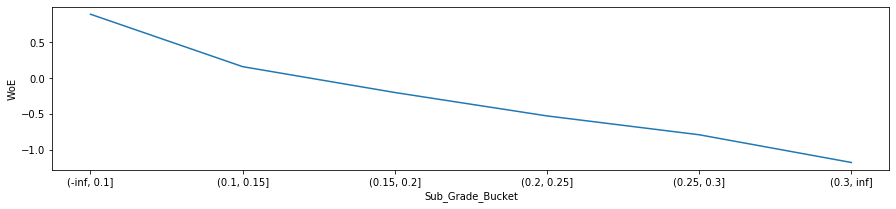

WOE is monotonically decreasing


In [31]:
# Third Most important variable is coming as Sub Grade.
# We can not take any call on sub grade specifically as its just a sub type of a Loan.
# But at the time of collection we need to put more effort based on sub grade.

x=woe[woe['Variable']=="Sub_Grade_Bucket"].sort_values('WoE',ascending=False)['Cutoff']
y=woe[woe['Variable']=="Sub_Grade_Bucket"].sort_values('WoE',ascending=False)['WoE']
f = plt.figure()
f.set_figwidth(15)
f.set_figheight(3)
plt.xlabel('Sub_Grade_Bucket')
plt.ylabel('WoE')
plt.plot(x, y)
plt.show()
print("WOE is monotonically decreasing")

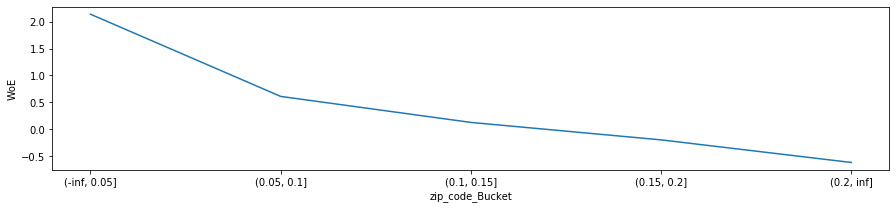

WOE is monotonically decreasing


In [32]:
# Forth Most important variable is coming as Zip-Code.
# We can not take any call on zipcode specifically as its just a zipcode. We can't say if you are coming from this zipcode we will no give loan to you.
# But at the time of collection we need to put more effort based on zipcode.

x=woe[woe['Variable']=="zip_code_Bucket"].sort_values('WoE',ascending=False)['Cutoff']
y=woe[woe['Variable']=="zip_code_Bucket"].sort_values('WoE',ascending=False)['WoE']
f = plt.figure()
f.set_figwidth(15)
f.set_figheight(3)
plt.xlabel('zip_code_Bucket')
plt.ylabel('WoE')
plt.plot(x, y)
plt.show()
print("WOE is monotonically decreasing")

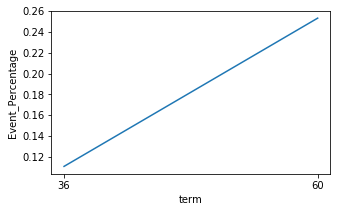

Lower the term lesser the chance of default
WOE is monotonically decreasing


In [33]:
# Fifth Most important variable is coming as Term.
# We can not take any call on term as higher the tenure higher the profit but in return higher the chances of default.
# But at the time of collection we need to put more effort based on term.

x=woe[woe['Variable']=="term"].sort_values('WoE',ascending=False)['Cutoff']
y=woe[woe['Variable']=="term"].sort_values('WoE',ascending=False)['Event_Percentage']
f = plt.figure()
f.set_figwidth(5)
f.set_figheight(3)
plt.xlabel('term')
plt.ylabel('Event_Percentage')
plt.plot(x, y)
plt.show()
print("Lower the term lesser the chance of default")
print("WOE is monotonically decreasing")

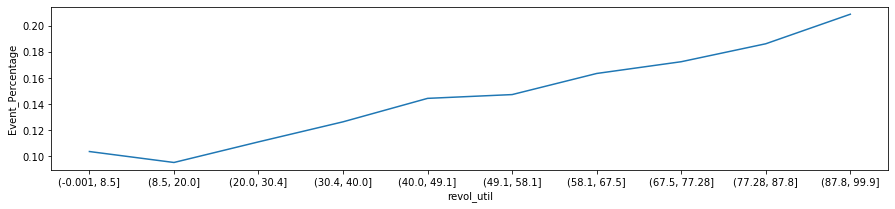

Lower the revol_util lesser the chance of default
WOE is monotonically decreasing


In [34]:
# sixth Most important variable is coming as revol_util.
# We can take a call on this. We can use this variable at the time of aquisition.
# customer with higher revol_util tends to do more default so we can give higher interest rate or not give the loan at all.

x=woe[woe['Variable']=="revol_util"].sort_values('Cutoff_Min',ascending=True)['Cutoff']
y=woe[woe['Variable']=="revol_util"].sort_values('Cutoff_Min',ascending=True)['Event_Percentage']
f = plt.figure()
f.set_figwidth(15)
f.set_figheight(3)
plt.xlabel('revol_util')
plt.ylabel('Event_Percentage')
plt.plot(x, y)
plt.show()
print("Lower the revol_util lesser the chance of default")
print("WOE is monotonically decreasing")

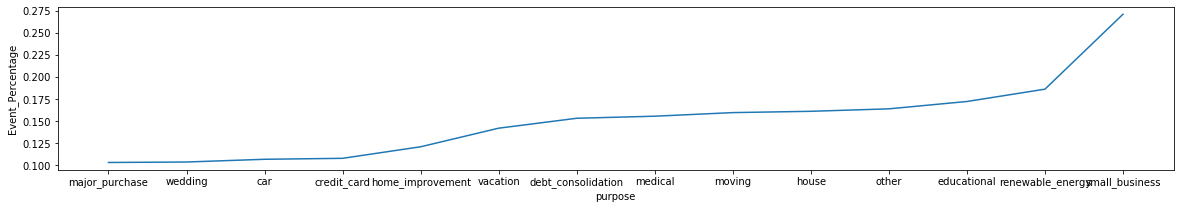

Small Business customer do more default
WOE is monotonically decreasing


In [35]:
# Seventh Most important variable is coming as purpose.
# We can take a call on this. We can use this variable at the time of aquisition.
# Customer giving purpose as small business tends to do more default.

x=woe[woe['Variable']=="purpose"].sort_values('WoE',ascending=False)['Cutoff']
y=woe[woe['Variable']=="purpose"].sort_values('WoE',ascending=False)['Event_Percentage']
f = plt.figure()
f.set_figwidth(20)
f.set_figheight(3)
plt.xlabel('purpose')
plt.ylabel('Event_Percentage')
plt.plot(x, y)
plt.show()
print("Small Business customer do more default")
print("WOE is monotonically decreasing")

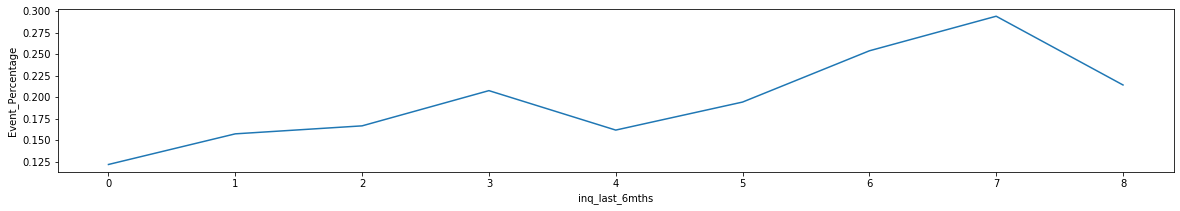

Higher the number of inquire higher the chance of default
WOE is monotonically decreasing


In [36]:
# Eigth Most important variable is coming as inq_last_6mths.
# We can take a call on this. We can use this variable at the time of aquisition.
# Higher the number of inquire higher the chance of default.
# This is logical as customer is not getting loan in the market thats why number of inquiry is high.

x=woe[woe['Variable']=="inq_last_6mths"].sort_values('Cutoff_Min',ascending=True)['Cutoff']
y=woe[woe['Variable']=="inq_last_6mths"].sort_values('Cutoff_Min',ascending=True)['Event_Percentage']
f = plt.figure()
f.set_figwidth(20)
f.set_figheight(3)
plt.xlabel('inq_last_6mths')
plt.ylabel('Event_Percentage')
plt.plot(x, y)
plt.show()
print("Higher the number of inquire higher the chance of default")
print("WOE is monotonically decreasing")

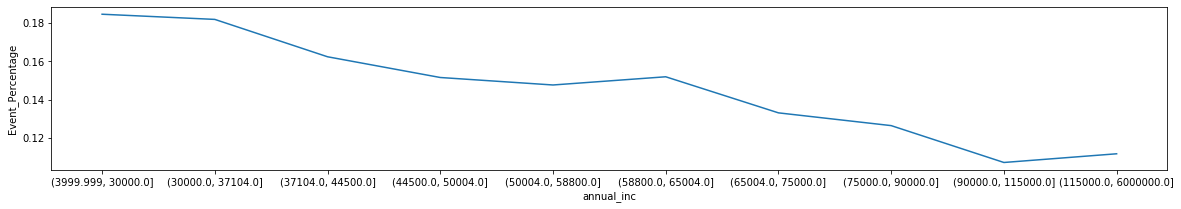

Higher the annual_inc less the chances of default
WOE is monotonically increasing


In [37]:
# Ninth Most important variable is coming as annual_inc.
# We can take a call on this. We can use this variable at the time of aquisition.
# Higher the annual_inc lower the chance of default.
# need to sync this with verification flag
# need to check this variable with verification status

x=woe[woe['Variable']=="annual_inc"].sort_values('Cutoff_Min',ascending=True)['Cutoff']
y=woe[woe['Variable']=="annual_inc"].sort_values('Cutoff_Min',ascending=True)['Event_Percentage']
f = plt.figure()
f.set_figwidth(20)
f.set_figheight(3)
plt.xlabel('annual_inc')
plt.ylabel('Event_Percentage')
plt.plot(x, y)
plt.show()
print("Higher the annual_inc less the chances of default")
print("WOE is monotonically increasing")

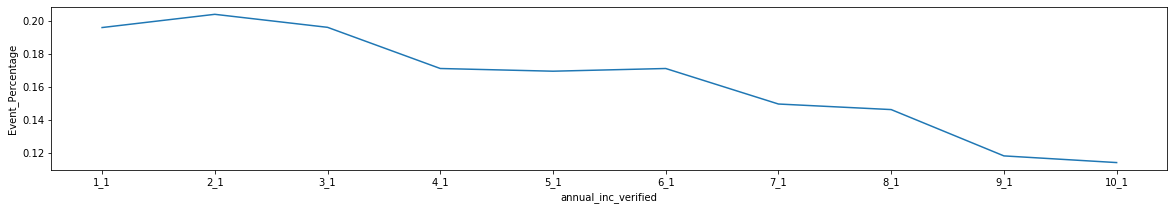

Higher the annual_inc higher the chance of default
WOE is monotonically increasing


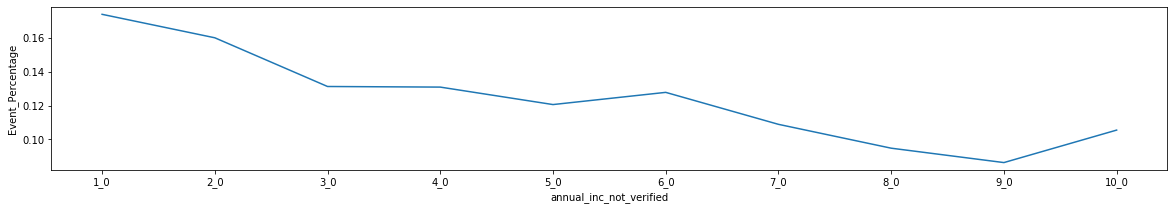

Higher the annual_inc higher the chance of default
WOE is monotonically increasing


In [38]:
# Checking annual income with reference to verification status

Model_Building['annual_inc_bucket']=pd.cut(Model_Building['annual_inc'],[-np.Inf,30000,37104,44500,50004,58800,65004,75000,90000,115000,np.Inf],labels=[1,2,3,4,5,6,7,8,9,10])
Model_Building['verification_status']=np.where(Model_Building['verification_status'].isin(['Source Verified','Verified']),1,0)
Model_Building['annual_inc_bucket_Verification_Status']=Model_Building['annual_inc_bucket'].astype(str)+'_'+Model_Building['verification_status'].astype(str)

woe_1=Model_Building.groupby(['annual_inc_bucket_Verification_Status']).agg({'id':'count','loan_status':'sum'}).reset_index(drop=False)
woe_1['Variable']="annual_inc_bucket_Verification_Status"
woe_1.columns=['Cutoff','N','Events','Variable']
woe_1=woe_1[['Variable','Cutoff','N','Events']]
woe_1['% of Events']=woe_1['Events']/sum(woe_1['Events'])
woe_1['Non-Events']=woe_1['N']-woe_1['Events']
woe_1['% of Non-Events']=woe_1['Non-Events']/sum(woe_1['Non-Events'])
woe_1['WoE'] = np.log(woe_1['% of Non-Events']/woe_1['% of Events'])
woe_1['IV'] = woe_1['WoE'] * (woe_1['% of Non-Events']-woe_1['% of Events'])
woe_1['Event_Percentage']=woe_1['Events']/woe_1['N']
woe_1['Cutoff_Min']=[i.split("_")[1] for i in woe_1['Cutoff']]
woe_1[woe_1['Variable']=="annual_inc_bucket_Verification_Status"].sort_values(['Cutoff_Min','Cutoff'],ascending=False)

woe_1_verified=woe_1[woe_1['Cutoff_Min']=='1']
woe_1_verified['Cutoff_Min']=[i.split("_")[0] for i in woe_1_verified['Cutoff']]
woe_1_verified['Cutoff_Min']=woe_1_verified['Cutoff_Min'].astype(int)
x=woe_1_verified.sort_values('Cutoff_Min',ascending=True)['Cutoff']
y=woe_1_verified.sort_values('Cutoff_Min',ascending=True)['Event_Percentage']

f = plt.figure()
f.set_figwidth(20)
f.set_figheight(3)
plt.xlabel('annual_inc_verified')
plt.ylabel('Event_Percentage')
plt.plot(x, y)
plt.show()
print("Higher the annual_inc higher the chance of default")
print("WOE is monotonically increasing")

woe_1_not_verified=woe_1[woe_1['Cutoff_Min']=='0']
woe_1_not_verified['Cutoff_Min']=[i.split("_")[0] for i in woe_1_not_verified['Cutoff']]
woe_1_not_verified['Cutoff_Min']=woe_1_not_verified['Cutoff_Min'].astype(int)
x=woe_1_not_verified.sort_values('Cutoff_Min',ascending=True)['Cutoff']
y=woe_1_not_verified.sort_values('Cutoff_Min',ascending=True)['Event_Percentage']

f = plt.figure()
f.set_figwidth(20)
f.set_figheight(3)
plt.xlabel('annual_inc_not_verified')
plt.ylabel('Event_Percentage')
plt.plot(x, y)
plt.show()
print("Higher the annual_inc higher the chance of default")
print("WOE is monotonically increasing")

In [39]:
# IV of annual_income with verification status is higher than normal annual income
# so keeping combined variable
print(sum(woe_1['IV']))
print(sum(woe[woe['Variable']=="annual_inc"]['IV']))

0.06935673346767564
0.040865757469748784


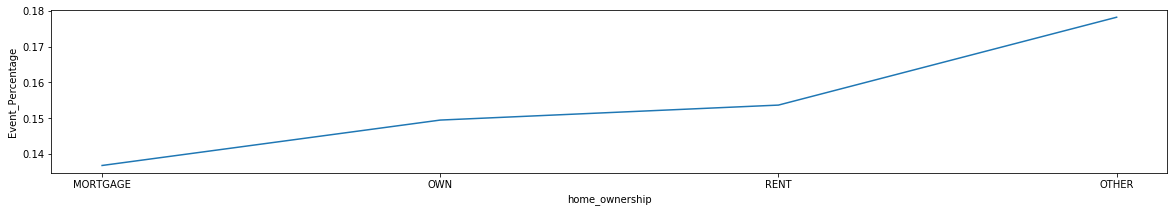

Home ownership as Other tends to do more default
WOE is monotonically decreasing


In [40]:
# Tenth Most important variable is coming as home_ownership.
# We can take a call on this. We can use this variable at the time of aquisition.
# Customer not owning property tends to do more default

x=woe[woe['Variable']=="home_ownership"].sort_values('WoE',ascending=False)['Cutoff']
y=woe[woe['Variable']=="home_ownership"].sort_values('WoE',ascending=False)['Event_Percentage']
f = plt.figure()
f.set_figwidth(20)
f.set_figheight(3)
plt.xlabel('home_ownership')
plt.ylabel('Event_Percentage')
plt.plot(x, y)
plt.show()
print("Home ownership as Other tends to do more default")
print("WOE is monotonically decreasing")

###### Two ways we can reduce the risk.

1. By focusing on customer at time of collection.\
    a. Int_Rate :- Need to focus on collection and put more effort on customer having higher interest rate. \
    b. Grade :- Grade G have higher chances of default need to focus on these type of customer more.\
    c. Sub Grade :- F2,G1,G5,F4,G2,G3,F5 need to focus on these category while collection. As chances of default is high.\
    d. Zipcode :- Need to focus on below list of zipcode as they have high chance of default.
        '871xx', '346xx', '925xx', '751xx', '630xx', '339xx', '488xx','330xx', '245xx', '207xx', '905xx', '914xx', '333xx',
        '331xx','234xx', '917xx', '305xx', '571xx', '628xx', '171xx', '128xx','657xx', '341xx', '148xx', '960xx', '347xx', 
        '065xx', '446xx','633xx', '360xx', '400xx', '754xx', '816xx', '119xx', '014xx','434xx', '344xx', '279xx', '285xx', 
        '983xx', '547xx', '616xx','172xx', '161xx', '037xx', '974xx', '984xx', '907xx', '363xx','081xx', '971xx', '856xx', 
        '844xx', '489xx', '013xx', '312xx','271xx', '302xx', '927xx', '444xx', '265xx', '238xx', '108xx','361xx', '321xx', 
        '349xx', '641xx', '906xx', '890xx', '623xx','259xx', '779xx', '106xx', '675xx', '325xx', '497xx', '795xx','725xx', 
        '154xx', '135xx', '593xx', '671xx', '487xx', '635xx','484xx', '546xx', '745xx', '449xx', '392xx', '056xx', '407xx',
       '367xx', '976xx', '937xx', '278xx', '354xx', '445xx', '439xx','072xx', '559xx', '283xx', '308xx', '153xx', '891xx',
       '082xx','147xx', '206xx', '224xx', '986xx', '614xx', '711xx', '626xx','447xx', '863xx', '826xx', '158xx', '615xx', 
       '422xx', '244xx','619xx', '997xx', '026xx', '187xx', '177xx', '570xx', '534xx','075xx', '935xx', '766xx', '807xx', 
       '758xx', '883xx', '035xx','859xx', '638xx', '425xx', '724xx', '264xx', '713xx', '316xx','376xx', '599xx', '668xx', 
       '406xx', '409xx', '639xx', '912xx','924xx', '253xx', '611xx', '499xx', '573xx', '755xx', '438xx','215xx', '808xx',
       '744xx', '719xx', '203xx', '608xx', '607xx','897xx', '413xx', '798xx', '673xx', '496xx', '416xx','685xx','746xx', 
       '561xx', '833xx', '663xx', '385xx', '669xx', '373xx','689xx', '094xx', '999xx'
    e. Term :- Customer taking loan for 60 Months have high chance of default. Need to focus at the time of collection.



2. By Changing Aquisition Score model and including below variables.\
    a. revol_util :- Customer with higher revol_util tends to do more default.\
    b. purpose :- Purpose as small business customer tends to default more.\
    c. inq_last_6mths :- Higher the number of inquire higher the chance of default.\
    d. annual income with reference to verification status :- Higher the income in both cases higher the chance of default.\
    e. home_ownership :- Home ownership as Other tends to do more default.

In [41]:
Model_Building['loan_status'].value_counts()

0    32915
1     5627
Name: loan_status, dtype: int64